# Controle e Qualidade e Semicondutores (SECOM)

## Introdução

Um processo de fabricação de semicondutores modernos está normalmente sob consistante vigilância por meio do monitoramento de sinais/variáveis ​​coletados de sensores e/ou pontos de medição do processo. 


## Dataset

O dataset usado é uma seleção de medidas associadas a recursos e os rótulos representam um classificação de aprovação/reprovação para cada linha de teste, onde -1 corresponde a um passe e 1 corresponde a uma falha.

Link do dataset: <a href="https://archive.ics.uci.edu/ml/datasets/SECOM" target="_blanck"> UCI - SECOM Data Set </a>

## Objetivo do projeto:

Através dos dados sobre semicondutores, vamos tentar prever se um determinado semicondutor passará ou reprovará em um teste de controle de qualidade. 

## Importando as Bibliotecas e os Dados

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('uci-secom.csv')
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


## Preprocessamento

Vamos processar o dataset, limpando os dados nulos, separando as variáveis, e normalizando os valores.

In [65]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Apaga coluna Time
    df = df.drop('Time', axis=1)
    
    # Apaga as colunas com mais de 25% de dados nulos
    missing_value_columns = df.columns[df.isna().mean() >= 0.25]
    df = df.drop(missing_value_columns, axis=1)
    
    # Preenche os valores faltantes com zero
    for column in df.columns:
        df[column] = df[column].fillna(0)
    
    
    # Cria rótulos textuais 
    df['Pass/Fail'] = df['Pass/Fail'].replace({-1: "Aprovado", 1: "Reprovado"})
    
    # Divide o dataset em X e y
    y = df['Pass/Fail']
    X = df.drop('Pass/Fail', axis=1)
    
    # Divide em conjunto de treino e de teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Normaliza os valores de X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [66]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

Vamos definir uma função capaz de calcular as métricas para avaliar os modelos.

In [68]:
def evaluate_model(model, X_test, y_test):
    
    # Calcula acurácia
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    # Faz a previsão dos dados
    y_pred = model.predict(X_test)
    
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=['Aprovado', 'Reprovado'])
    
    # Calcula as métricas precision, recall e f1-score
    clr = classification_report(y_test, y_pred, labels=['Aprovado', 'Reprovado'])
    
    # Desenha a matriz de confusão usando um mapa de calor
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=['Aprovado', 'Reprovado'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Aprovado', 'Reprovado'])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matrix de Confusão")
    plt.show()
    
    print("Relatório de Classificação:\n----------------------\n", clr)

## Examinando as Classes Desequilibradas

Neste dataset, o número de pontos de dados em uma classe (aprovado/reprovado) é muito maior do que o número de pontos de dados em outras classes. Quando isso acontece, o classificador tende a ser tendencioso. As classificações não refletirá a verdadeira natureza dos dados apenas porque há uma grande diferença no número de pontos de dados entre as duas classes. Portanto, torna-se importante dar conta dessa discrepância e neutralizá-la para que nosso classificador permaneça imparcial. 

In [81]:
# Visualizar o número de dados para cada classe (desiquilibrada)
y_train.value_counts()

Aprovado     1024
Reprovado      72
Name: Pass/Fail, dtype: int64

### Treinando o Modelo (Desequilibrado)

O modelo escolhido foi o LogistcRegression, por ser um algoritmo que responde muito bem a classificações binárias. Vamos começar treinando o modelo com os ddos ainda desequilibrados.

Accuracy: 89.17%


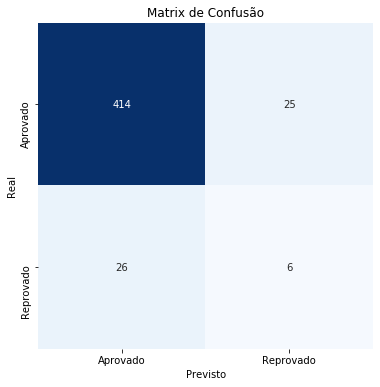

Relatório de Classificação:
----------------------
               precision    recall  f1-score   support

    Aprovado       0.94      0.94      0.94       439
   Reprovado       0.19      0.19      0.19        32

    accuracy                           0.89       471
   macro avg       0.57      0.57      0.57       471
weighted avg       0.89      0.89      0.89       471



In [69]:
model = LogisticRegression()
model.fit(X_train, y_train)

evaluate_model(model,X_test, y_test)

O classificador foi incapaz de separar as duas classes, resultando em 0.19% de precisão para a classe 'Reprovado'.

### Usando Random Oversampling

A biblioteca *imblearn* gera novas amostras das classes
minoritárias. A função *RandomOverSampling* seleciona amostras aleatórias e as adiciona na classe minoritária. 

In [71]:
oversampler = RandomOverSampler(random_state=1)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [86]:
# Exibe as classes equilibradas
print("Nova amostragem de classes usando RandomOverSampling")
y_train_os.value_counts()

Nova amostragem de classes usando RandomOverSampling


Aprovado     1024
Reprovado    1024
Name: Pass/Fail, dtype: int64

Accuracy: 85.77%


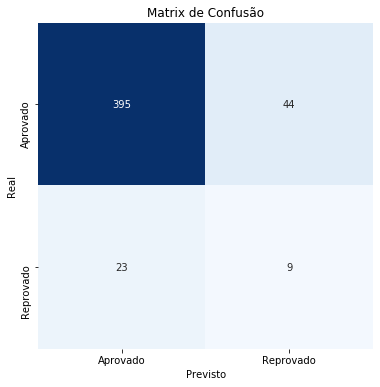

Relatório de Classificação:
----------------------
               precision    recall  f1-score   support

    Aprovado       0.94      0.90      0.92       439
   Reprovado       0.17      0.28      0.21        32

    accuracy                           0.86       471
   macro avg       0.56      0.59      0.57       471
weighted avg       0.89      0.86      0.87       471



In [73]:
modelos = LogisticRegression()
modelos.fit(X_train_os, y_train_os)

evaluate_model(modelos, X_test, y_test)

### Usando Oversampling com SMOTE

O SMOTE funciona selecionando um de seus k vizinhos mais próximos, conectando uma linha a um deles e selecionando um ponto nessa linha, gerando novas amostras para a classe minoritária.

In [74]:
oversampler = SMOTE(random_state=1)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [85]:
# Exibe as classes equilibradas
print("Nova amostragem de classes usando SMOTE")
y_train_smote.value_counts()


Nova amostragem de classes usando SMOTE


Aprovado     1024
Reprovado    1024
Name: Pass/Fail, dtype: int64

Accuracy: 85.99%


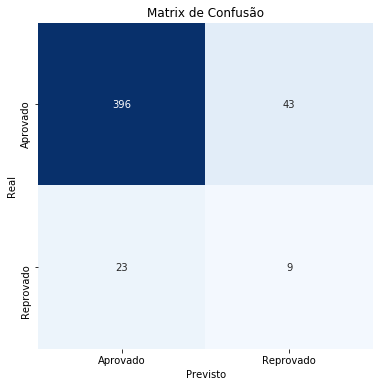

Relatório de Classificação:
----------------------
               precision    recall  f1-score   support

    Aprovado       0.95      0.90      0.92       439
   Reprovado       0.17      0.28      0.21        32

    accuracy                           0.86       471
   macro avg       0.56      0.59      0.57       471
weighted avg       0.89      0.86      0.87       471



In [76]:
modelsm = LogisticRegression()
modelsm.fit(X_train_smote, y_train_smote)

evaluate_model(modelsm, X_test, y_test)

## Usando RandomUnderSampling

Outro método para equilibrar classes é baixar aleatoriamente as amostras das classes majoritárias. Para isso usamos a função *RandomUnderSampling*.

In [77]:
undersampler = RandomUnderSampler(random_state=1)
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

In [87]:
# Exibe as classes equilibradas
print("Nova amostragem de classes usando RandomUnderSampling")
y_train_us.value_counts()

Nova amostragem de classes usando RandomUnderSampling


Reprovado    72
Aprovado     72
Name: Pass/Fail, dtype: int64

Accuracy: 85.77%


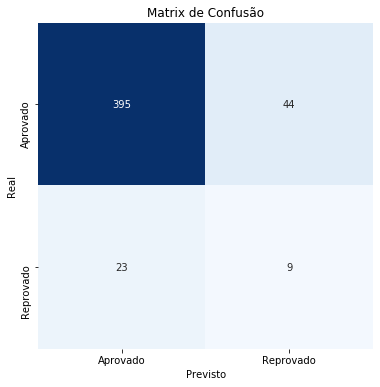

Relatório de Classificação:
----------------------
               precision    recall  f1-score   support

    Aprovado       0.94      0.90      0.92       439
   Reprovado       0.17      0.28      0.21        32

    accuracy                           0.86       471
   macro avg       0.56      0.59      0.57       471
weighted avg       0.89      0.86      0.87       471



In [78]:
modelus = LogisticRegression()
modelus.fit(X_train_os, y_train_os)

evaluate_model(modelus, X_test, y_test)

### Usando NearMiss

A função *NearMiss* abaixa a classe maior removendo amostras que estão próximas umas das outras.

In [79]:
undermiss = NearMiss()
X_train_nm, y_train_nm = undermiss.fit_resample(X_train, y_train)

In [53]:
# Exibe as classes equilibradas
print("Nova amostragem de classes usando NearMiss")
y_train_nm.value_counts()

PASS    72
FAIL    72
Name: Pass/Fail, dtype: int64

Accuracy: 54.78%


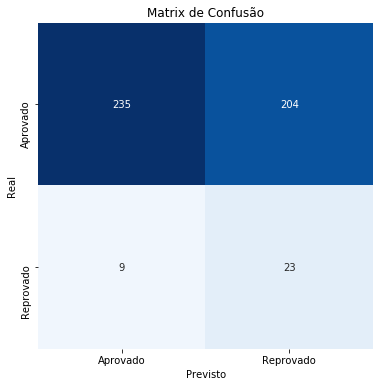

Relatório de Classificação:
----------------------
               precision    recall  f1-score   support

    Aprovado       0.96      0.54      0.69       439
   Reprovado       0.10      0.72      0.18        32

    accuracy                           0.55       471
   macro avg       0.53      0.63      0.43       471
weighted avg       0.90      0.55      0.65       471



In [80]:
modelnm = LogisticRegression()
modelnm.fit(X_train_nm, y_train_nm)

evaluate_model(modelnm, X_test, y_test)

## Conclusão

Usando o modelo LogisticRegression, criamos vários classificadores para realizar o tste de qualidade de semicondutors.

Como a quantidade de classes aprovado/reprovado no dataset estava desequilibrada (muito mais de uma do que da outra), usamos algoritmos para tanto aumentar o número de amostras da classe minoritária quanto para baixar o númeo de amostras da classe maoritária.